# Some studies about Delta-z effect


### Nov 2020, JAH

In [52]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [53]:
import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt

to_df = pd.DataFrame.from_records

import invisible_cities.core.fit_functions as fitf

In [54]:
import hipy.utils        as ut
import hipy.pltext       as pltext
import hipy.hfit         as hfit

import bes.bes           as bes

In [55]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Sat Nov 14 18:26:27 2020


### Load data

In [56]:
def get_filename(run_number):
    datadir    = f"/data_extra2/jrenner/analysis/NEW"
    run_number = str(run_number)
    filename   = datadir + f'/{run_number}' + f'/hdf5/cdst/trigger2/cdst_combined_{run_number}' + '.h5'
    return filename

def append_dfs(dfs):
    df = None
    for i, idf in enumerate(dfs):
        df = idf if i == 0 else df.append(idf, ignore_index = True)
    return df

In [57]:
runs      = [8182, 8183, 8184]
filenames = [get_filename(run) for run in runs]
dds       = [bes.get_df_zeffect(filename) for filename in filenames]
dd        = append_dfs(dds)

In [58]:
dd['S2eq']      = dd['evt_energy']/dd['S2q']
dd['blob1_eta'] = (dd['blob1_z'] - dd['z_min'])/dd['dz_track']
dd['blob2_eta'] = (dd['blob2_z'] - dd['z_min'])/dd['dz_track']

print(len(dd))
print(list(dd.columns))

3204576
['event', 'trackID', 'energy', 'length', 'numb_of_voxels', 'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'r_min', 'x_max', 'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'r_ave', 'extreme1_x', 'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y', 'extreme2_z', 'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y', 'blob2_z', 'eblob1', 'eblob2', 'ovlp_blob_energy', 'dz_track', 'enecor', 'time', 'nS2', 'S1e', 'S2e', 'S2q', 'Nsipm', 'evt_energy', 'evt_ntrks', 'evt_nhits', 'S2eq', 'blob1_eta', 'blob2_eta']


In [59]:
ranges                   = bes.get_ranges()
ranges['eblob2.soft']    = (0.2, 1.)
ranges['nS2.one']        = (0.5, 1.5)
ranges['S2e']            = (2.5e5, 1e8)
ranges['enecor.ds.hard'] = (1.630, 1.700)
ranges['enecor.ph.hard'] = (2.600, 2.900)
print('ranges', [(key, ranges[key]) for key in ranges.keys()])


selections   = bes.get_selections(dd, ranges)
selections['fidutial'] = selections.logical_and('numb_of_tracks.one', 'z_min', 'z_max', 'r_max', 'energy') 
#                                                'nS2.one', 'S2e')
print('selections : ', list(selections.keys()))

ranges [('numb_of_tracks.one', (0.5, 1.5)), ('nS2', (0.5, 1.5)), ('energy', (0.0, 3.0)), ('energy.cs', (0.65, 0.71)), ('energy.ds', (1.55, 1.75)), ('energy.ph', (2.5, 3.0)), ('enecor.cs', (0.65, 0.71)), ('enecor.ds', (1.55, 1.75)), ('enecor.ph', (2.5, 3.0)), ('z_min', (50.0, 500.0)), ('z_max', (50.0, 500.0)), ('r_max', (0.0, 180.0)), ('dz_track.cs', (8.0, 32.0)), ('dz_track.ds', (24.0, 72.0)), ('dz_track.ph', (35.0, 130.0)), ('eblob2.soft', (0.2, 1.0)), ('nS2.one', (0.5, 1.5)), ('S2e', (250000.0, 100000000.0)), ('enecor.ds.hard', (1.63, 1.7)), ('enecor.ph.hard', (2.6, 2.9))]
selections :  ['numb_of_tracks.one', 'nS2', 'energy', 'energy.cs', 'energy.ds', 'energy.ph', 'enecor.cs', 'enecor.ds', 'enecor.ph', 'z_min', 'z_max', 'r_max', 'dz_track.cs', 'dz_track.ds', 'dz_track.ph', 'eblob2.soft', 'nS2.one', 'S2e', 'enecor.ds.hard', 'enecor.ph.hard', 'fidutial']


## Delta-z effect

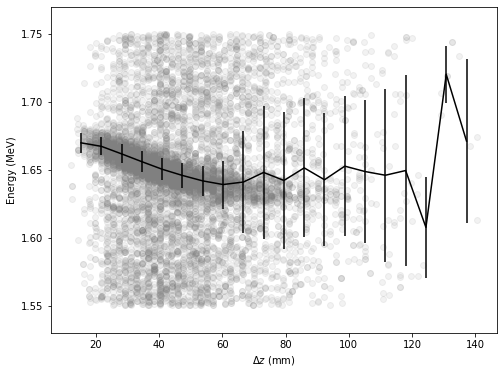

In [60]:
xsel = selections.logical_and('fidutial', 'energy.ds')
pltext.canvas(1, 1, 6, 8)

enes, dzs = dd[xsel].energy.values, dd[xsel].dz_track.values
plt.scatter(dzs, enes, alpha = 0.1, c='grey');
xs, ys, eys = pltext.hprofile_in_sigma(dzs, enes, nsigma = 2.5);
plt.xlabel(r'$\Delta z$ (mm)'); plt.ylabel('Energy (MeV)');
## TODO: fit to a straight-line

## Delta-z effect correction

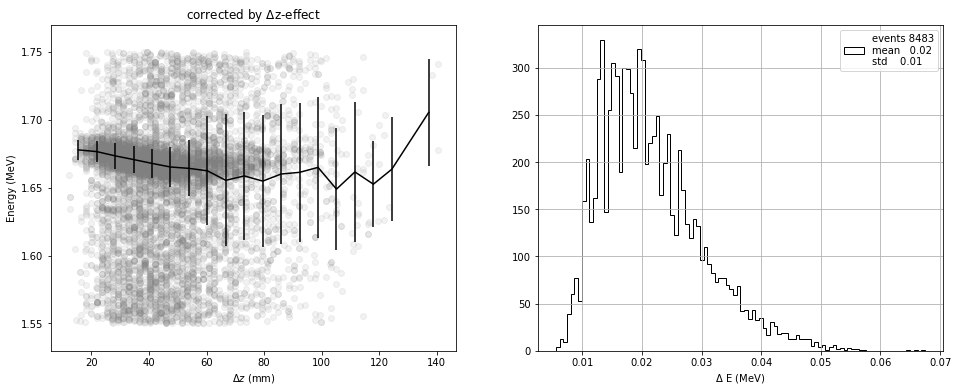

In [61]:
xsel = selections.logical_and('fidutial', 'enecor.ds')
subplot = pltext.canvas(2, 2, 6, 8)

subplot(1)
enes, dzs = dd[xsel].enecor.values, dd[xsel].dz_track.values
plt.scatter(dzs, enes, alpha = 0.1, c='grey');
xs, ys, eys = pltext.hprofile_in_sigma(dzs, enes, nsigma = 2.5);
plt.xlabel(r'$\Delta z$ (mm)'); plt.ylabel('Energy (MeV)'); plt.title('corrected by $\Delta$z-effect')

subplot(2)
denes, dzs = dd[xsel].enecor.values - dd[xsel].energy.values, dd[xsel].dz_track.values
pltext.hist(denes, 100, xylabels = r'$\Delta$ E (MeV)');


## TODO: fit to a straight-line

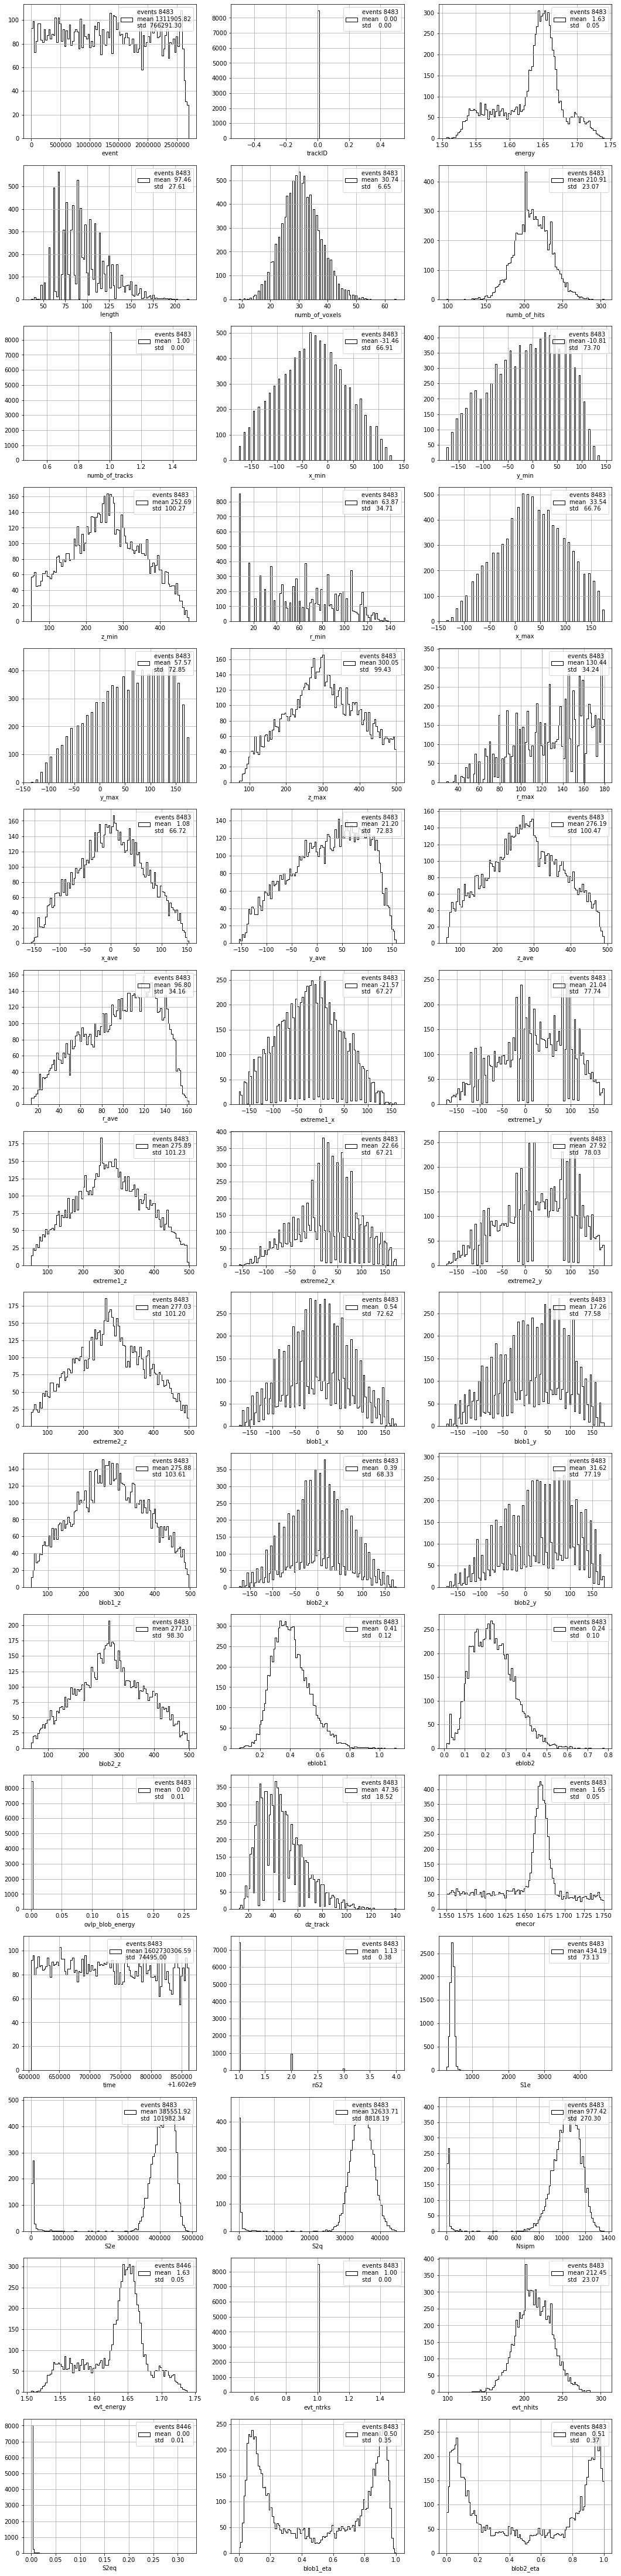

In [62]:
xsel = selections.logical_and('fidutial', 'enecor.ds')
pltext.plt_inspect_df(dd[xsel], ncolumns = 3)

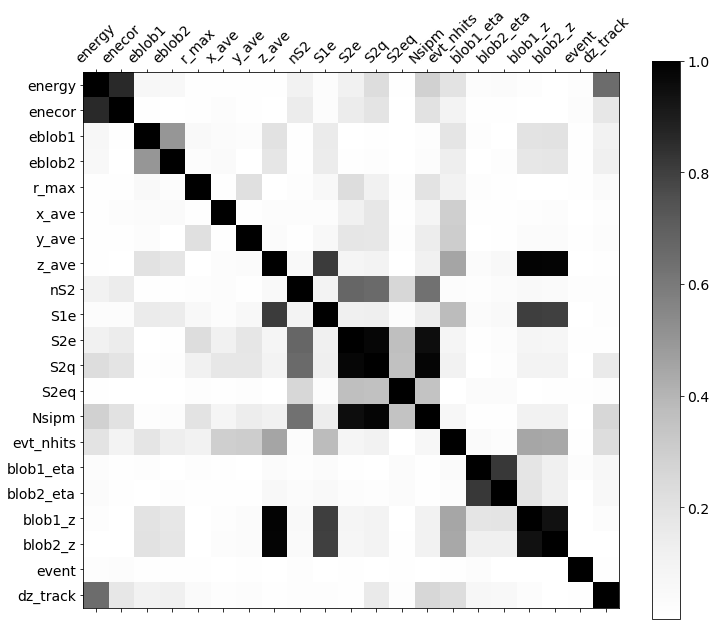

In [63]:
xsel = selections.logical_and('fidutial', 'enecor.ds.hard', 'eblob2.soft')

labels = ['energy', 'enecor', 'eblob1', 'eblob2', 
          'r_max', 'x_ave', 'y_ave', 'z_ave',
          'nS2', 'S1e', 'S2e', 'S2q', 'S2eq', 'Nsipm', 'evt_nhits',
          'blob1_eta', 'blob2_eta',
          'blob1_z', 'blob2_z', 'event', 'dz_track']

pltext.corrmatrix(dd[xsel], labels)

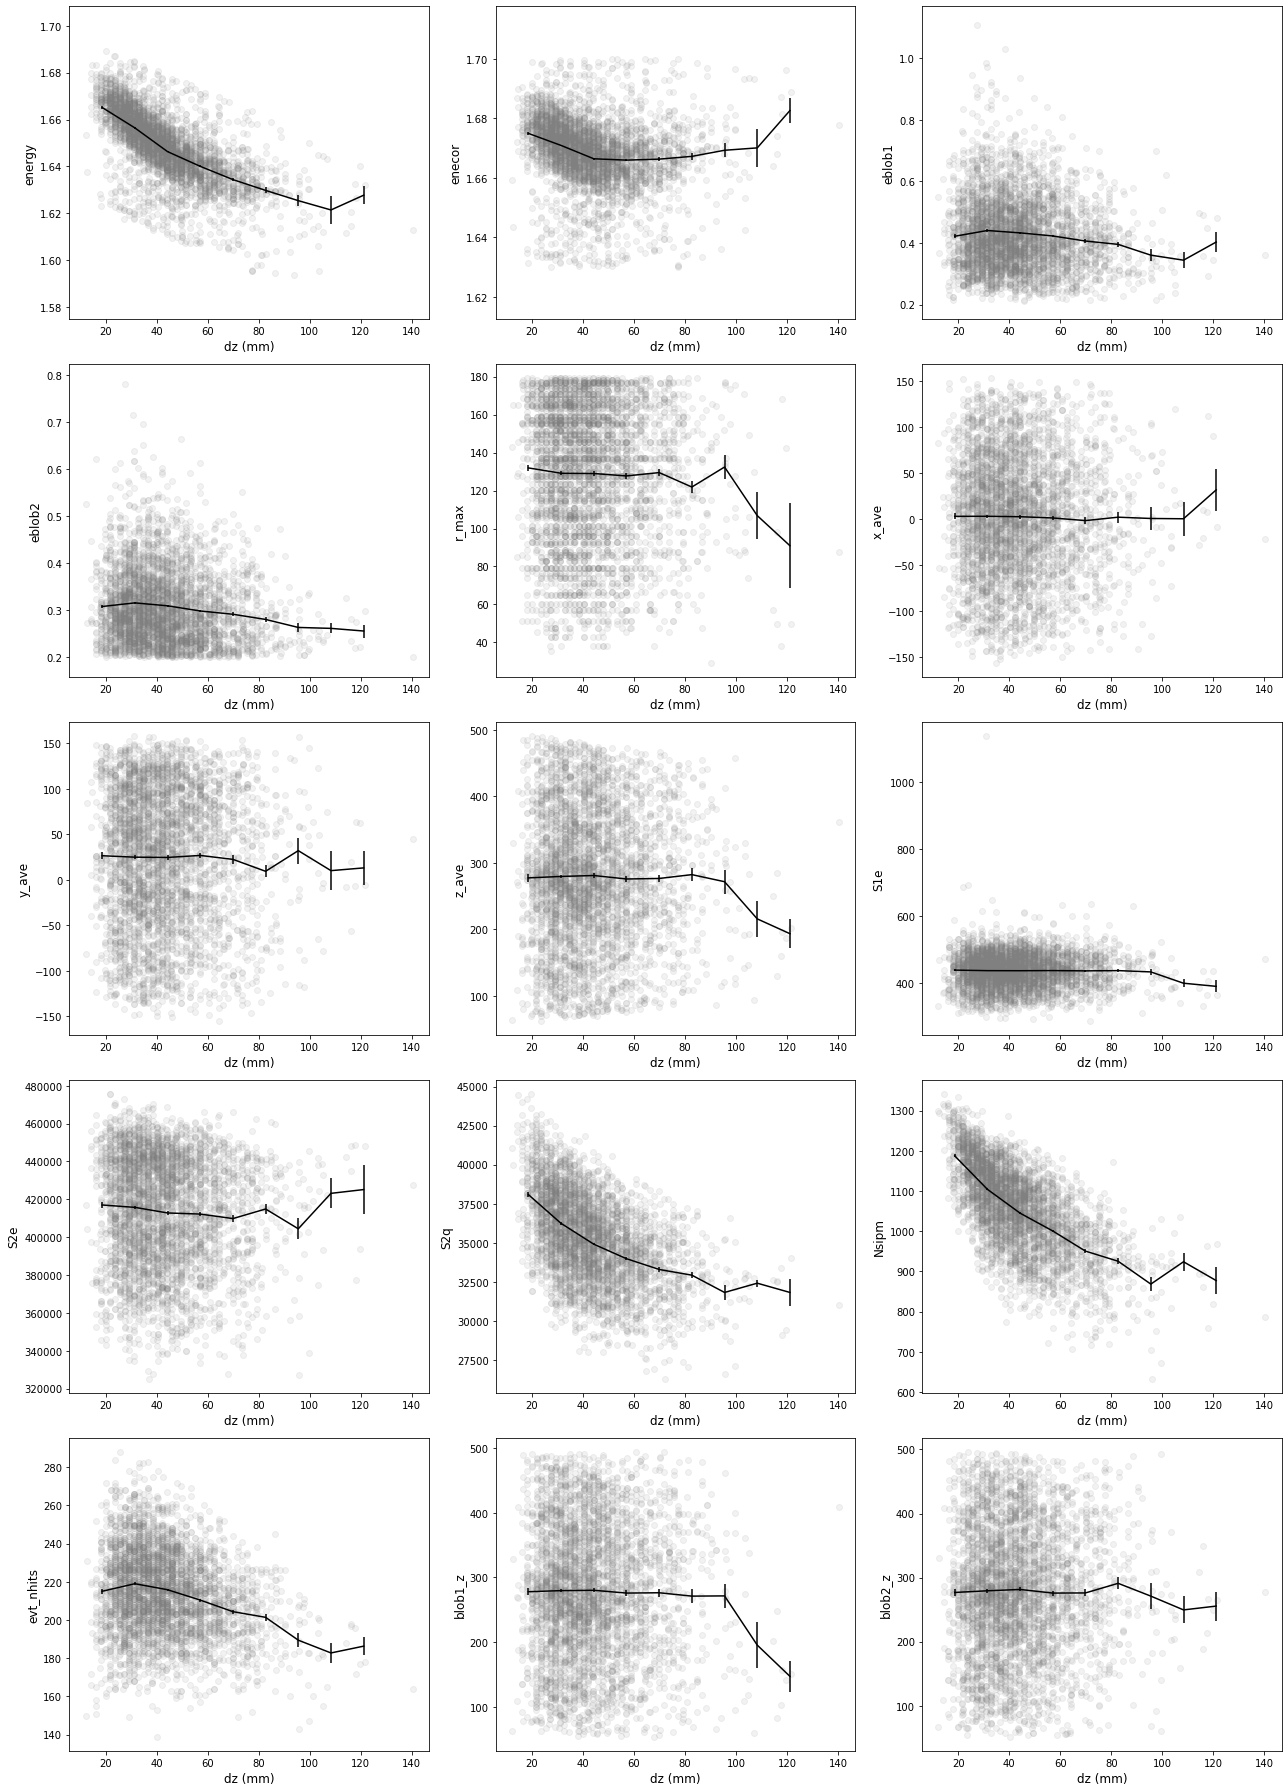

In [65]:
labels = ['energy', 'enecor', 'eblob1', 'eblob2', 
          'r_max', 'x_ave', 'y_ave', 'z_ave',
          'S1e', 'S2e', 'S2q', 'Nsipm', 'evt_nhits',
          'blob1_z', 'blob2_z']

xsel = selections.logical_and('fidutial', 'enecor.ds.hard', 'eblob2.soft', 'S2e')
#xsel = selections.logical_and('fidutial', 'enecor.cs')

subplot = pltext.canvas(len(labels), 3)
for i, label in enumerate(labels):
    subplot(i + 1)
    plt   .scatter(dd[xsel].dz_track, dd[xsel][label], alpha = 0.1, c = 'grey')
    pltext.hprofile(dd[xsel].dz_track, dd[xsel][label])
    plt.xlabel('dz (mm)', fontsize = 12); plt.ylabel(label, fontsize = 12);
plt.tight_layout()

AttributeError: module 'hipy.pltext' has no attribute 'hpscatter'

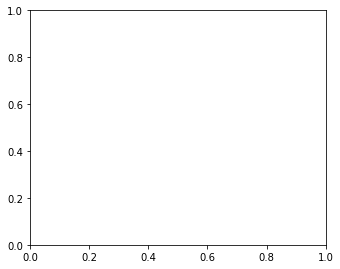

In [66]:
subplot = pltext.canvas(len(labels), 3)
for i, label in enumerate(labels):
    subplot(i + 1)
    x, y = dd[xsel][label], dd[xsel]['energy']/dd[xsel].enecor-1.
    plt   .scatter(x, y, apl)
    pltext.hpscatter(dd[xsel][label], (dd[xsel]['energy']/dd[xsel].enecor-1.), alpha = 0.2, c = 'grey')
    plt.ylabel(r'$\Delta$ E (MeV)', fontsize = 12); plt.xlabel(label, fontsize = 12);
plt.tight_layout()